# A Variational Convolutional Autoencoder for unsupervised features extraction of ceramic profiles.  A case study from central Italy.

###  Importing libreries

In [1]:
# Pytorch
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.preprocessing import MinMaxScaler

# Utils
from utils_and_plotting import LoadPots, PlotRecostruction, PlottingEmbeddings, KdePlot, WSDist
from Pots_nn_train import potds_torch, TrainingVAE, TestingVAE

#### Set a random seed for reproducibility

In [2]:
# Set a random seed for reproducibility
def my_seed(seed):

    print("Selected seed: ",seed,"")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

In [3]:
my_seed(396)

Selected seed:  396 


#### Set GPU as primary device for computation

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Selected device: {device}")

Selected device: cuda


## Loading data

In [5]:
pots = LoadPots("Latium_Etruria_pots.npz")
archeo_info = pd.read_csv("Etruria_Latium_ds.csv")

In [6]:
archeo_info

,ids,context_name,context_typology,chronology,funerary_function,context_id,Morphology,Functional_class,Region
0,ACQRSS_0001,Acquarossa,Settlement,EIA2,NaN,363,Open shape,Class 1,Etruria
1,ALTR_CNL_0003,Alatri - Canale,Settlement,FBA,NaN,386,Open shape,Class 1,Latium
2,ANGN_SNT_CECL_0001,Anagni - Santa Cecilia,Cultual,OP,NaN,528,Closed shape,Class 4,Latium
3,ANGN_SNT_CECL_0002,Anagni - Santa Cecilia,Cultual,OP,NaN,528,Closed shape,Class 4,Latium
4,ANGN_SNT_CECL_0003,Anagni - Santa Cecilia,Cultual,OP,NaN,528,Closed shape,Class 4,Latium
...,...,...,...,...,...,...,...,...,...
4987,VLL_PZZ_0003,Valle Pozzo,Funerary,EIA1,Grave good,145,Closed shape,Class 4,Latium
4988,VLL_PZZ_0004,Valle Pozzo,Funerary,EIA1,Grave good,145,Closed shape,Class 4,Latium
4989,VLL_PZZ_0005,Valle Pozzo,Funerary,EIA1,Grave good,145,Closed shape,Class 4,Latium
4990,VLL_PZZ_0006,Valle Pozzo,Funerary,FBA,Grave good,145,Open shape,Class 2,Latium


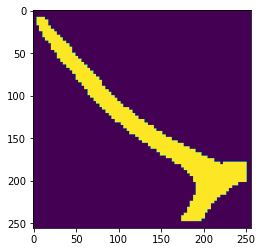

In [7]:
plt.imshow(pots[0])

## Try to use an interactive widget to get information about dataset 

### Define Hyperparameters

In [8]:
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.001
LATENT_DIMS = 10

### Prepare data for Autoencoder

#### Train & Test split

In [9]:
trn, tst = train_test_split(pots, test_size=0.20)
print("Train size:  "+ str(len(trn)))
print("Test size:  "+ str(len(tst)))

Train size:  3993
Test size:  999


#### Setting up Dataset transformation

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [11]:
potds_pytorch_trn = potds_torch(trn, transform=transform)
potds_pytorch_tst = potds_torch(tst, transform=transform)
potds_pytorch = potds_torch(pots, transform=transform)

In [12]:
data_loader_train = DataLoader(dataset = potds_pytorch_trn, batch_size=BATCH_SIZE, shuffle=True)
data_loader_test = DataLoader(dataset = potds_pytorch_tst, batch_size=64, shuffle=True)
data_loader_eval = DataLoader(dataset = potds_pytorch, batch_size=64, shuffle=False)

##### Checking Batch shape and length

In [13]:
x= next(iter(data_loader_train))
x.shape

torch.Size([128, 1, 256, 256])

#### View a Batch

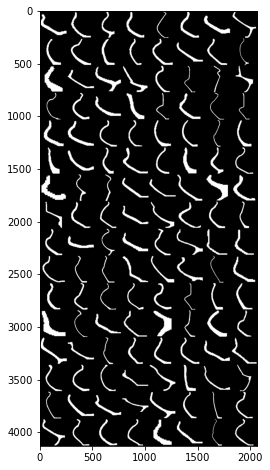

In [14]:
im = make_grid(x, nrow=8)

plt.figure(figsize=(24,8))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

### Define Autoencoder structure and parameters

In [15]:
from Pots_nn_train import VariationalAutoencoder

In [16]:
### Instancing the model
vae = VariationalAutoencoder(latent_dims=LATENT_DIMS)
### Define loss function and optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
# Define Recostruction Loss
loss_fn = F.mse_loss

In [17]:
### View the number of tunable parameter
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters: " + str(count_parameters(vae)))

Total number of parameters: 2306293


In [18]:
vae.to(device)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): ReLU(inplace=True)
    (15): Linear(in_features=8192, o

## Training time!

In [19]:
outputs_train, losses_train = TrainingVAE(vae, EPOCHS, data_loader_train,  device, loss_fn, optimizer)

Epoch [1/50] Batch 1/32, Loss : 21162.4355
Epoch [1/50] Batch 2/32, Loss : 20891.3652
Epoch [1/50] Batch 3/32, Loss : 20551.8770
Epoch [1/50] Batch 4/32, Loss : 20300.7383
Epoch [1/50] Batch 5/32, Loss : 20049.1934
Epoch [1/50] Batch 6/32, Loss : 19830.2246
Epoch [1/50] Batch 7/32, Loss : 19627.7793
Epoch [1/50] Batch 8/32, Loss : 19461.5020
Epoch [1/50] Batch 9/32, Loss : 19223.2520
Epoch [1/50] Batch 10/32, Loss : 18976.8047
Epoch [1/50] Batch 11/32, Loss : 18826.6719
Epoch [1/50] Batch 12/32, Loss : 18666.2148
Epoch [1/50] Batch 13/32, Loss : 18458.7109
Epoch [1/50] Batch 14/32, Loss : 18286.3516
Epoch [1/50] Batch 15/32, Loss : 18185.0137
Epoch [1/50] Batch 16/32, Loss : 17979.9609
Epoch [1/50] Batch 17/32, Loss : 17862.2734
Epoch [1/50] Batch 18/32, Loss : 17625.4336
Epoch [1/50] Batch 19/32, Loss : 17530.0547
Epoch [1/50] Batch 20/32, Loss : 17368.8730
Epoch [1/50] Batch 21/32, Loss : 17145.5840
Epoch [1/50] Batch 22/32, Loss : 17074.9277
Epoch [1/50] Batch 23/32, Loss : 16859.86

### Plot Training recostruction

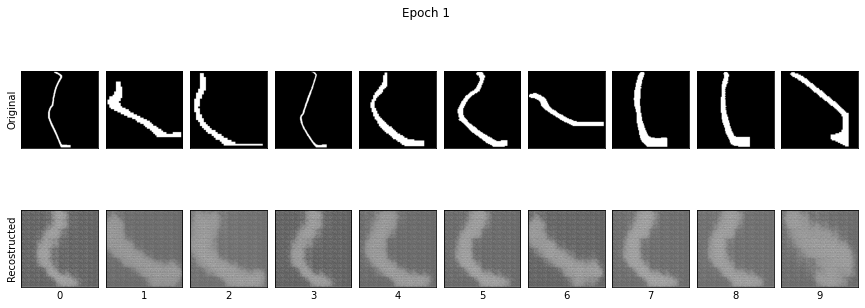

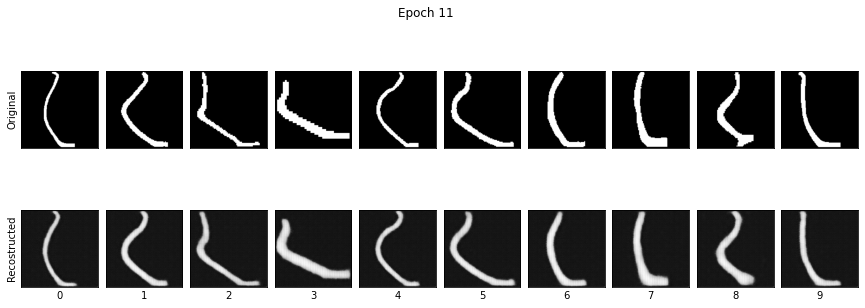

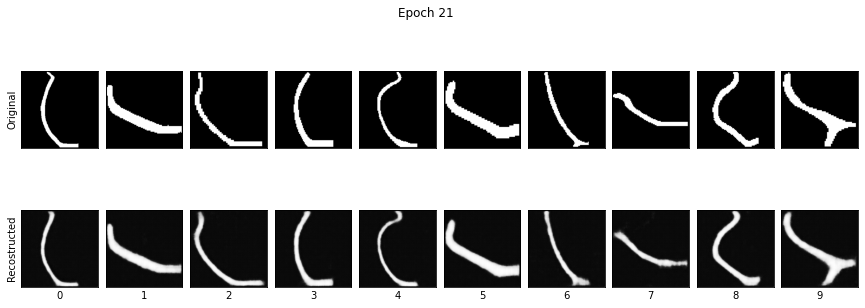

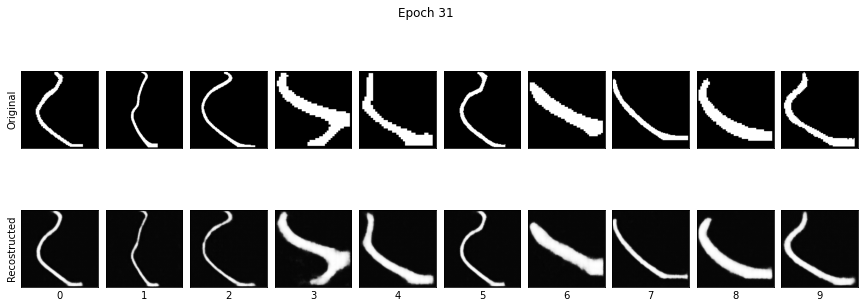

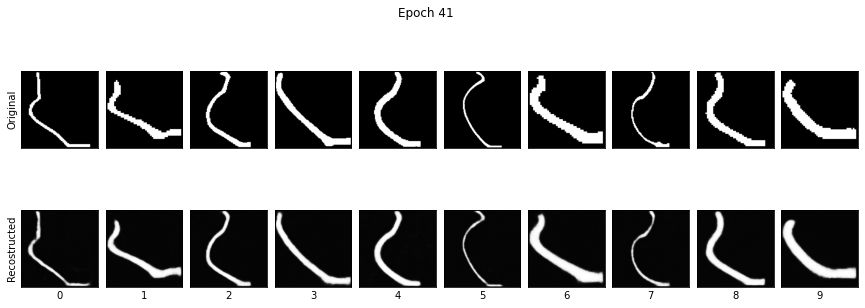

In [20]:
PlotRecostruction(outputs_train, start = 0, stop = EPOCHS, plt_range = 10, plt_number = 10, QuickCleaning=False,SaveFig=False)

## Testing 

In [21]:
outputs_tst, losses_tst = TestingVAE(vae, EPOCHS, data_loader_test,  device, loss_fn)

Mean test loss: 1137.41


#### Plotting Test dataset

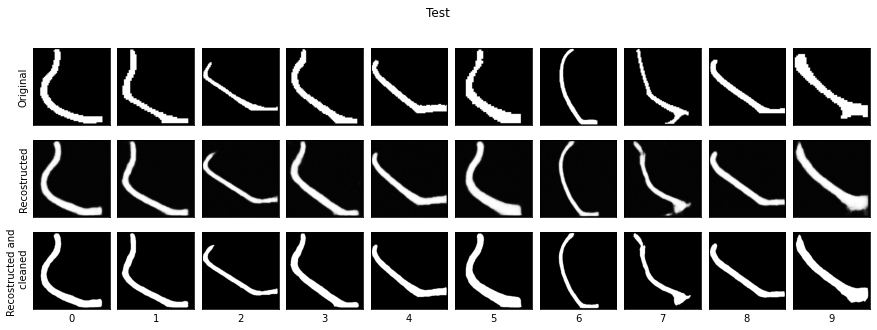

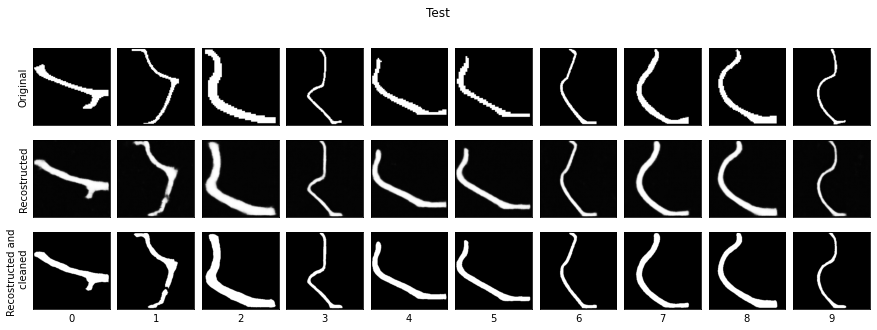

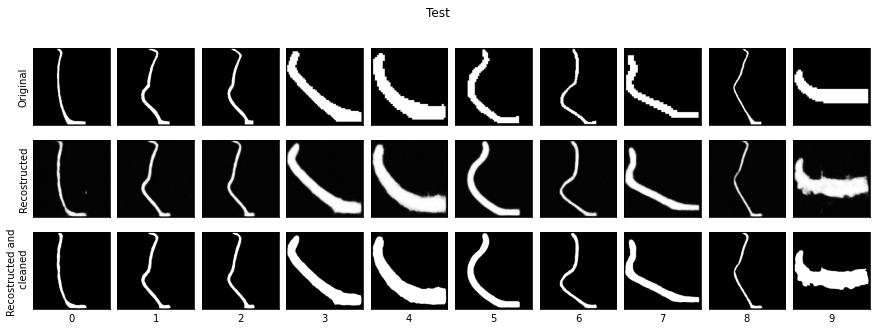

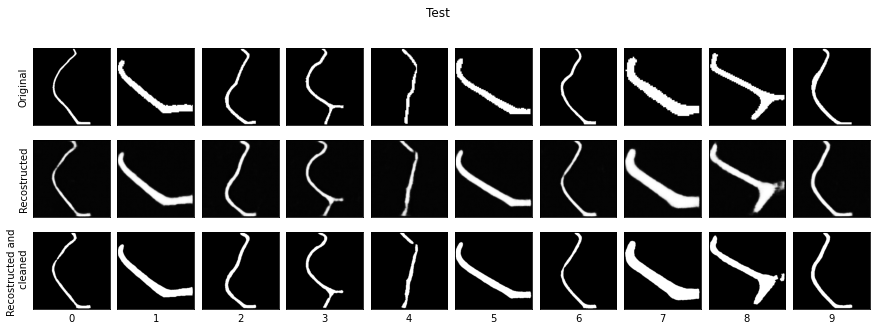

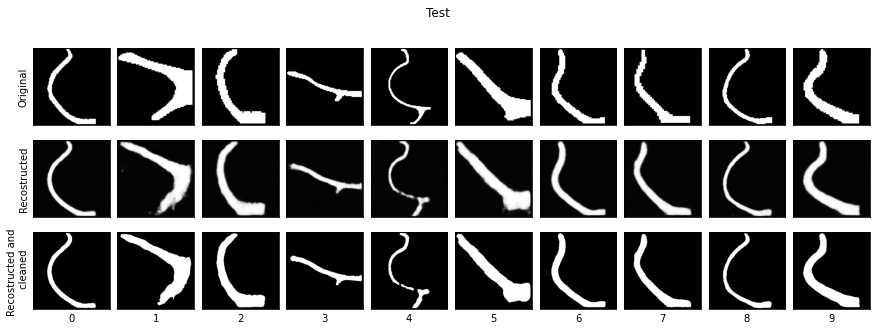

In [22]:
PlotRecostruction(outputs_tst, start = 0, stop = EPOCHS, plt_range = 10, plt_number = 10, QuickCleaning=True, Training = False)

### Plotting Train and Test Loss

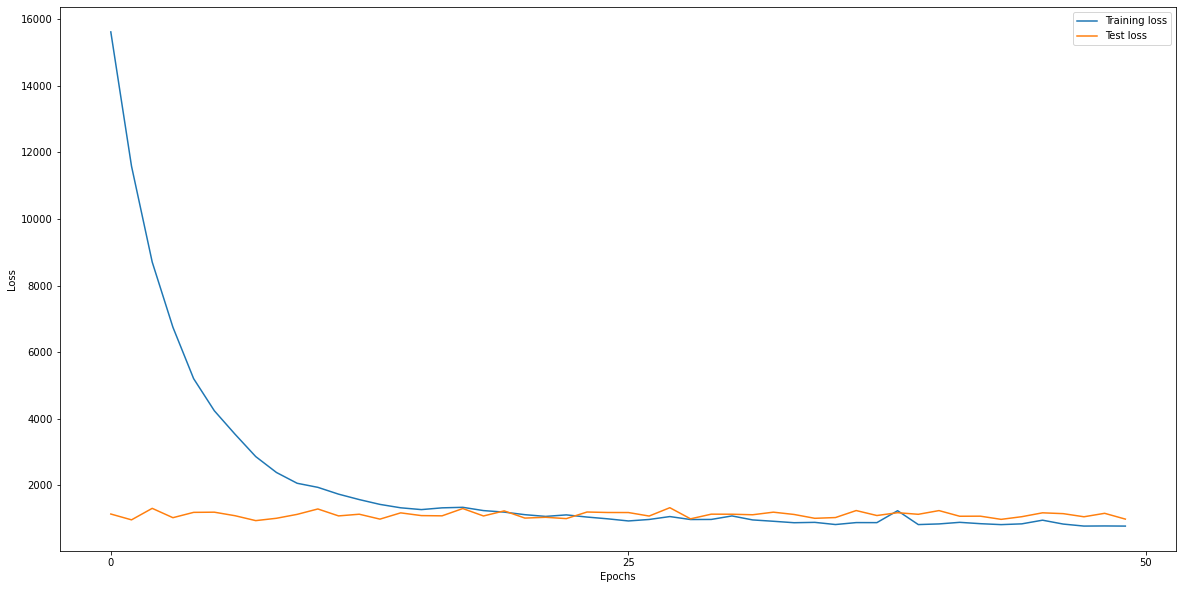

In [23]:
plt.figure(figsize=(20,10))
plt.plot((np.array(losses_train))[:,1], label = "Training loss")
plt.xticks(np.arange(0, EPOCHS+1, EPOCHS//2))
plt.plot((np.array(losses_tst))[:,1], label = "Test loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

# Accessing Latent Dimension

In [24]:
encoded_samples = []
for b, img in enumerate(data_loader_eval):
    img = img.to(device)
    vae.to(device)
    vae.eval()
    with torch.no_grad():
        encoded_img, _, _, _  = vae(img.float())
        encoded_img = encoded_img.cpu().numpy()
    encoded_samples.extend(encoded_img)
    encoded_dim = np.array(encoded_samples)

In [25]:
# Check encoded spaces dimension
encoded_dim.shape

(4992, 10)

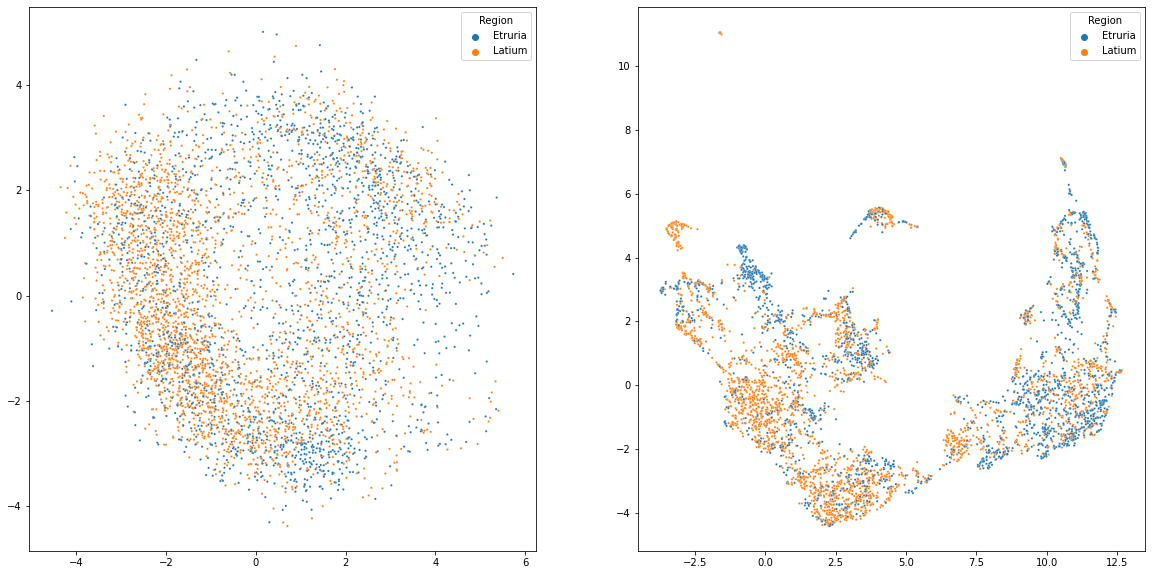

In [26]:
PlottingEmbeddings(encoded_dim, archeo_info, labels = "Region")

### Normalize encoded dimension

In [27]:
# Instance MinMaxScaler class
mm = MinMaxScaler()
# Normalize encoded data
encoded_dim_df = pd.DataFrame(encoded_dim, archeo_info.index)
encoded_dim = mm.fit_transform(encoded_dim)
encoded_df_norm = pd.DataFrame(encoded_dim, archeo_info.index)

In [28]:
encoded_df_norm.head()

,0,1,2,3,4,5,6,7,8,9
0,0.444342,0.636509,0.270109,0.381341,0.784004,0.320028,0.455724,0.210009,0.458406,0.671725
1,0.761405,0.440617,0.571072,0.240546,0.655508,0.419307,0.418210,0.604044,0.431824,0.132363
2,0.398200,0.504146,0.323944,0.500736,0.447185,0.722542,0.648418,0.888136,0.431171,0.223447
3,0.396266,0.480574,0.296072,0.541509,0.501369,0.641791,0.671792,0.831681,0.502868,0.174540
4,0.421399,0.362826,0.231463,0.549065,0.481946,0.576920,0.648347,0.817602,0.455136,0.290429


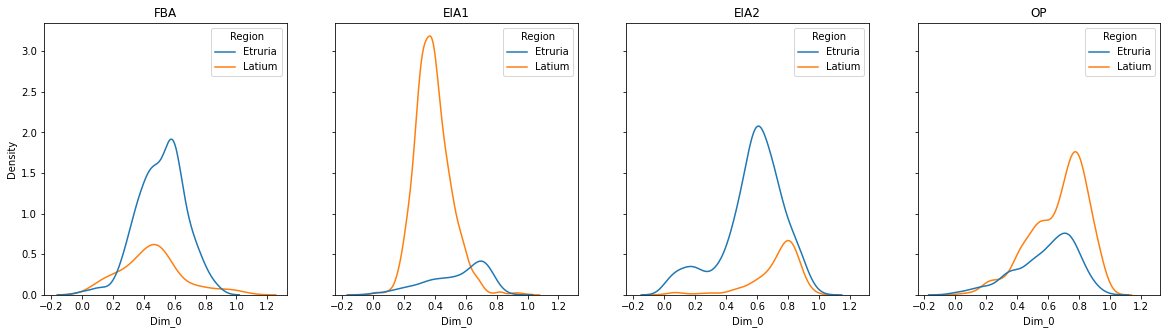

In [29]:
KdePlot(encoded_df_norm, archeo_info, subsampling = False, SaveFig=True)

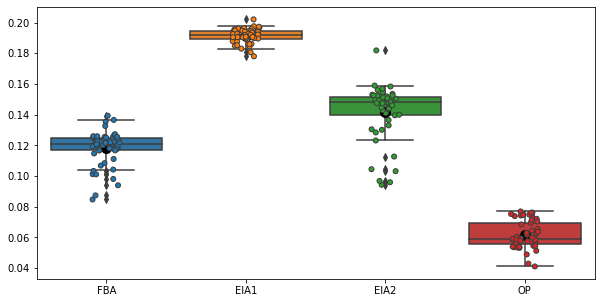

In [30]:
WSDist(encoded_df_norm, archeo_info, 50, SaveFig = True, PlotType = "boxplot", show_points= True)

In [ ]:
subsampling  = True
ess = []
distance_ws = []

hue_order = ["Etruria", "Latium"]
for n in range(50):
    with pd.option_context('mode.chained_assignment',None):

        for x, i in enumerate(chronology):
            info_selected_chrono = archeo_info[(archeo_info.chronology == i)]
            pots_chrono = encoded_df_norm.loc[info_selected_chrono.index]

            if subsampling == True:

                #############
                selected_subsample = []
                min_number = min(info_selected_chrono.value_counts("Region"))
                max_index = np.argmax(info_selected_chrono.value_counts("Region"))
                max_region = info_selected_chrono.value_counts("Region").index[max_index]

                info_selected_chrono_max_region = info_selected_chrono[(info_selected_chrono.Region == max_region)]
                info_selected_chrono_min_region = info_selected_chrono[(info_selected_chrono.Region != max_region)]
                random_select = info_selected_chrono_max_region.sample(n = min_number)
                
                list1, list2 = list(info_selected_chrono_min_region.index), list(random_select.index)

                list1.extend(list2)

                info_selected_chrono = info_selected_chrono.loc[list1]
                pots_chrono = pots_chrono.loc[list1]

                ############

                    


            lda = NCA(pots_chrono, info_selected_chrono.Region, init = "pca", n_components=1, random_state = 1 )
            lda_comp_norm = mm.fit_transform(lda.components)
            df_values = pd.DataFrame(lda_comp_norm, columns=[f"Dim_{dim}" for dim in range(lda.components.shape[1])] , index = info_selected_chrono.index)
                

            info_selected_chrono_joined = info_selected_chrono.join(df_values)

            

            ess.append(info_selected_chrono_joined)



        total_df = pd.concat(ess)



        for x, i in enumerate(chronology):
            total_df_chr = total_df[(total_df.chronology == i)]
            reg = total_df_chr[["Region", "Dim_0"]]
            reg_lat = reg[reg.Region == "Latium"]
            reg_etr = reg[reg.Region == "Etruria"]
            w_d = wasserstein_distance(reg_lat["Dim_0"], reg_etr["Dim_0"])



            distance_ws.append((n, i, w_d))

df_dist = pd.DataFrame(distance_ws, columns =  [["Run", "Epochs", "Wasserstain"]])



In [ ]:
df_dist.head()

In [ ]:
ax = sns.boxplot(x = df_dist["Epochs"].values.reshape(-1), y =df_dist["Wasserstain"].values.reshape(-1), showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
ax = sns.stripplot(x=df_dist["Epochs"].values.reshape(-1), y=df_dist["Wasserstain"].values.reshape(-1),  linewidth=1)